# An inverted pendulum on a cart: Linearized state-space model
&copy; 2023 @RR_Inyo<br/>
Released under the MIT license<br/>
https://opensource.org/licenses/mit-license.php<br/>

This version of notebook make use of scipy.integrate.solve_ivp instead of odeint.

Fig. 1 shows an inverted pendulum on a cart.
<figure><img src="inverted-pendulum-on-cart-with-disturbance.png"><figcaption>Fig. 1 Inverted pendulum on a cart</figcaption></figure><br/>
The motion equation of the system has been derived as follows.
$$
\begin{align}
(M + m) \ddot{x}_{c} + m l \ddot{\theta} \cos \theta &= -\mu_{c} \dot{x}_{c} + m l \dot{\theta}^{2} \sin \theta + f \tag{1} \\[10pt]
m l \ddot{x}_{c} \cos \theta + (J + m l^{2}) \ddot{\theta} &= -\mu_{p} \dot{\theta} + m g l \sin \theta + \underbrace{f_{d} \cos \theta}_{\mathrm{Disturbance}} \tag{2}
\end{align}
$$

In this form, it cannot be used as an input differential equation system for `scipy.integrate.solve_ivp` function. If we choose
$$\boldsymbol{x} = [x_c, \dot{x}_c, \theta, \dot{\theta}]^T$$
as the state variable, (1) and (2) shall be reorganized to obtain $\ddot{x}_{c}$ and $\ddot{\theta}$, which has been derived by SymPy in another notebook. The resultant equations are too complicated to print here. Nontheless, the function `func` below uses the results.

Linearization of the original non-linear dynamics gives the following state-space model.
$$
\displaystyle \frac{d}{dt}
\begin{bmatrix}
\Delta x_{c} \\\Delta \dot{x}_{c} \\ \Delta \theta \\ \Delta \dot{\theta}
\end{bmatrix}
=
\begin{bmatrix}
0 & 1 & 0 & 0 \\
0 & -K \mu_{c} (J + m l^{2}) & -K m^{2} l^{2} g & K \mu_{p} m l \\
0 & 0 & 0 & 1 \\
0 & K \mu_{c} m l & K m l g (M + m) & -K \mu_{p} (M + m)
\end{bmatrix}
\begin{bmatrix}
\Delta x_{c} \\ \Delta \dot{x}_{c} \\\Delta \theta \\ \Delta \dot{\theta}
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 \\
K (J + m l^{2}) & -K m l \\
0 & 0 \\
-K m l & K (M + m)
\end{bmatrix}
\begin{bmatrix}
\Delta f \\\Delta f_{d}
\end{bmatrix} \tag{3}
$$
where
$$
K = \displaystyle \frac{1}{J (M + m) + M m l^{2}} \tag{4}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from scipy.linalg import solve_continuous_are
from scipy.integrate import solve_ivp
from scipy.constants import g
from IPython.display import HTML

In [2]:
np.set_printoptions(formatter=None)

In [3]:
# Parameters
M = 1.00                  # Mass of cart
m = 0.75                  # Mass of pendulum, kg
l = 0.30                  # Half length, m
J = m * l**2 / 3          # Inertia around center of mass, kg m**2
mu_c = 0.050              # Friction of cart, N/(m/s)
mu_p = 0.050              # Friction of pendulum, Nm/(rad/s)

In [4]:
# Matrices as a result of linearization
K = 1 / (J * (M + m) + M * m * l**2)
A = np.array([[0, 1, 0, 0],
              [0, -K * mu_c * (J + m * l**2), -K * m**2 * l**2 * g, mu_p * m * l],
              [0, 0, 0, 1],
              [0, K * mu_c * m * l, K * m * l * g * (M + m), -K * mu_p * (M + m)]])
B = np.array([[0, 0],
              [K * (J + m * l**2), -K * m * l],
              [0, 0],
              [-K * m * l, K * (M + m)]])

# Reduced system: If position of cart, x_c, is not be cared
A_r = A[1:,1:]
B_r = B[1:,:]

In [5]:
# Confirm eigenvalue of A
print(f'A =\n{A}')
w, v = np.linalg.eig(A)
print(f'Eigenvalues =\n{w}')

A =
[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -4.21052632e-02 -4.64525526e+00  1.12500000e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00  1.05263158e-01  3.61297632e+01 -8.18713450e-01]]
Eigenvalues =
[ 0.         -0.02857895 -6.44052156  5.60828179]


In [6]:
# Check controllability
B_c = B[:, 0]  # Remove part of B for disturbance
print(f'B =\n{B_c}')
U_c = np.array([B_c,
                A @ B_c,
                A @ A @ B_c,
                A @ A @ A @ B_c])
print(f'U_c =\n{U_c}')
print(f'Rank of U_c = {np.linalg.matrix_rank(U_c)}')

B =
[ 0.          0.84210526  0.         -2.10526316]
U_c =
[[ 0.00000000e+00  8.42105263e-01  0.00000000e+00 -2.10526316e+00]
 [ 8.42105263e-01 -5.91412742e-02 -2.10526316e+00  1.81224992e+00]
 [-5.91412742e-02  9.80236274e+00  1.81224992e+00 -7.75525981e+01]
 [ 9.80236274e+00 -9.70356128e+00 -7.75525981e+01  1.30001343e+02]]
Rank of U_c = 4


In [7]:
# Check observability
C = np.array([1, 0, 0, 0])
U_o = np.array([C,
                C @ A,
                C @ A @ A,
                C @ A @ A @ A])
print(f'C = \n{C}')
print(f'U_o =\n{U_o}')
print(f'Rank of U_o = {np.linalg.matrix_rank(U_o)}')

C = 
[1 0 0 0]
U_o =
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -4.21052632e-02 -4.64525526e+00  1.12500000e-02]
 [ 0.00000000e+00  2.95706371e-03  6.02049531e-01 -4.65493947e+00]]
Rank of U_o = 4


In [8]:
# Check observability of reduced system
C_r = np.array([0, 0, 1])
U_or = np.array([C_r,
                 C_r @ A_r,
                 C_r @ A_r @ A_r])
print(U_or)
np.linalg.matrix_rank(U_or)

[[  0.           0.           1.        ]
 [  0.10526316  36.12976316  -0.81871345]
 [ -0.0906125  -30.06889729  36.80123908]]


3

In [9]:
# LQR, using linearized state-space model
# Weights
b = np.array([B[:, 0]]).T
Q = np.diag([1, 0, 500, 0])
R = np.array([[1]])

# Solve Riccati equation
P = solve_continuous_are(A, b, Q, R)
F = (-np.linalg.inv(R) @ b.T @ P)[0]
print(f'State-feedback gain F =\n{F}')

# Check eigenvalues of closed-loop system
w_lqr, v_lqr = np.linalg.eig(A + b * F)
print(f'Eigenvalues of closed-loop system =\n{w_lqr}')

State-feedback gain F =
[ 1.          2.72644047 52.27353179  7.65506225]
Eigenvalues of closed-loop system =
[-6.92096699+3.38181947j -6.92096699-3.38181947j -0.4194277 +0.41475428j
 -0.4194277 -0.41475428j]


In [10]:
# State feedback gain
# F = np.array([20, 30, 150, 30])
# F = np.array([0, 30, 150, 30])
# F = np.array([0, 0, 5, 120])
# F = np.array([20, 30, 115, 25])
x_ofs = np.array([0, 0, 0, 0])
f_max = 2000

In [11]:
# Force controller
# State x = [x_c, x_c_dot, theta, theta_dot]^T
def force_control(t, x):
    # Clip angle (theta) from -180 to 180 degree
    _x = x.copy()
    np.put(_x, 2, (x[2] + np.pi) % (2 * np.pi) - np.pi)
    
    # # Try swing up
    # if t < 1:
    #     # Standstill
    #     f = 0
    # elif 1 <= t < 1.3:
    #     f = -20
    # elif 1.3 <= t < 2:
    #     f = 12
    # elif 2 <= t < 12.5:
    #     # Normal control
    #     f = np.clip(np.dot(F, _x - x_ofs), -f_max, f_max)
    # else:
    #     # Quit contrlling
    #     f = 0
    
    if t < 15:
        f = np.clip(np.dot(F, _x - x_ofs), -f_max, f_max)
    else:
        f = 0
    
    return f

In [12]:
# Disturbance generator
# State x = [x_c, x_c_dot, theta, theta_dot]^T
def force_disturbance(t, x):
    if 5 <= t < 5.4:
        f_d = 1
    elif 9 <= t < 12:
        f_d = 1 * np.sin(2 * np.pi * 1 * (t - 9))
    else:
        f_d = 0
    return f_d

In [13]:
# Differential equation
# State x = [x_c, x_c_dot, theta, theta_dot]^T
def func(t, x):
    # Extract variables
    x_c, x_c_dot, theta, theta_dot = x
    
    # External force applied to cart as control input    
    f = force_control(t, x)
    
    # External force applied at tip of pendulum as disturbance
    f_d = force_disturbance(t, x)

    # Calculate x_ddot and theta_ddot
    denom = J * (M + m) + M * m * l**2 + (m * l * np.sin(theta))**2
    
    x_c_ddot = (J * f + J * m * l * theta_dot**2 * np.sin(theta) \
        - J * mu_c * x_c_dot + m * l**2 * f \
        - m * l * f_d * (np.cos(theta))**2 \
        - m**2 * l**2 * g * np.sin(theta) * np.cos(theta) \
        + m**2 * l**3 * theta_dot**2 * np.sin(theta) \
        - m * l**2 * mu_c * x_c_dot \
        + m * l * mu_p * theta_dot * np.cos(theta)) / denom
    
    theta_ddot = (M * f_d * np.cos(theta) \
        + M * m * g * l * np.sin(theta) - M * mu_p * theta_dot \
        - m * l * f * np.cos(theta) + m * f_d * np.cos(theta) \
        + m**2 * l * g * np.sin(theta) \
        - m**2 * l**2 * theta_dot**2 * np.sin(theta) * np.cos(theta) \
        + m * l * mu_c * x_c_dot * np.cos(theta) \
        - m * mu_p * theta_dot) / denom
    
    # Prepare empty array to store derivatives
    dxdt = np.zeros_like(x)
    
    # Differential equation
    dxdt[0] = x[1]
    dxdt[1] = x_c_ddot
    dxdt[2] = x[3]
    dxdt[3] = theta_ddot
    
    return dxdt

In [14]:
# Differential equation, linearized
# State x = [x_c, x_c_dot, theta, theta_dot]^T
def func_lin(t, x):
    # Extract variables
    x_c, x_c_dot, theta, theta_dot = x
    
    # External force applied to cart as control input    
    f = force_control(t, x)
    
    # External force applied at tip of pendulum as disturbance
    f_d = force_disturbance(t, x)
    
    u = np.array([f, f_d])
    
    # Prepare empty array to store derivatives
    dxdt = np.zeros_like(x)
    
    # Differential equation
    dxdt = A @ x + B @ u
    # dxdt = np.matmul(A, x) + np.matmul(B, u)
    
    return dxdt

In [15]:
# Solve, non-linear original
t_end = 20
dt = 0.01
t = np.arange(0, t_end, dt)
x_c0 = -1
theta_0 = -30
x0 = [x_c0, 0, np.radians(theta_0), 0]

sol = solve_ivp(func, [0, t_end], x0, t_eval = t)

In [16]:
# Post proccesing, non-linear original
x_c = sol.y[0,:].T
v_c = sol.y[1,:].T
theta = (sol.y[2,:].T + np.pi) % (2 * np.pi) - np.pi
omega = sol.y[3,:].T

In [17]:
# Reproduce control force, non-linear original
f_cont = np.zeros_like(t)
for i, _t in enumerate(t):
    f_cont[i] = force_control(_t, sol.y[:,i])

In [18]:
# Reproduce disturbance force, non-linear original
f_disturb = np.zeros_like(t)
for i, _t in enumerate(t):
    f_disturb[i] = force_disturbance(_t, sol.y[:,i])

In [19]:
# Solve, linearized
sol_lin = solve_ivp(func_lin, [0, t_end], x0, t_eval = t)

In [20]:
# Post proccesing, linearized
x_c_lin = sol_lin.y[0,:].T
v_c_lin = sol_lin.y[1,:].T
theta_lin = (sol_lin.y[2,:].T + np.pi) % (2 * np.pi) - np.pi
omega_lin = sol_lin.y[3,:].T

In [21]:
# Reproduce disturbance force, linearized
f_disturb_lin = np.zeros_like(t)
for i, _t in enumerate(t):
    f_disturb_lin[i] = force_disturbance(_t, sol_lin.y[:,i])

In [22]:
# Reproduce control force, linearized
f_cont_lin = np.zeros_like(t)
for i, _t in enumerate(t):
    f_cont_lin[i] = force_control(_t, sol_lin.y[:,i])

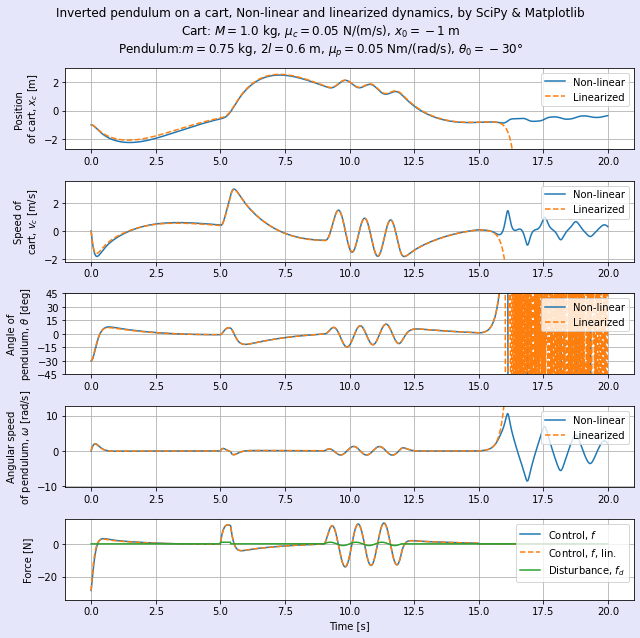

In [23]:
# Time-domain plots
plt.rcParams["font.size"] = 10
fig, ax = plt.subplots(5, 1, figsize = (9, 9))
fig.patch.set_facecolor('lavender')
#fig.suptitle(f'Inverted pendulum on a cart, $M = {M}$ kg, $m = {m}$ kg, $2l = {2 * l}$ m, $\mu_c = {mu_c}$ N/(m/s), $\mu_p = {mu_p}$ Nm/(rad/s)')
fig.suptitle(f'Inverted pendulum on a cart, Non-linear and linearized dynamics, by SciPy & Matplotlib\nCart: $M = {M}$ kg, $\mu_c = {mu_c}$ N/(m/s), $x_0 = {x_c0}$ m\nPendulum:$m = {m}$ kg, $2l = {2 * l}$ m, $\mu_p = {mu_p}$ Nm/(rad/s), $\\theta_0 = {theta_0}\degree$')

# Plot position of cart
ax[0].plot(t, x_c, label = 'Non-linear')
ax[0].plot(t, x_c_lin, label = 'Linearized', ls = '--')
ax[0].set_ylim(np.min(x_c) * 1.2, np.max(x_c) * 1.2)
ax[0].set_ylabel('Position\nof cart, $x_{c}$ [m]')
ax[0].legend(loc = 'upper right')
ax[0].grid()

# Plot speed of cart
ax[1].plot(t, v_c, label = 'Non-linear')
ax[1].plot(t, v_c_lin, label = 'Linearized', ls ='--')
ax[1].set_ylim(np.min(v_c) * 1.2, np.max(v_c) * 1.2)
ax[1].set_ylabel('Speed of\ncart, $v_{c}$ [m/s]')
ax[1].legend(loc = 'upper right')
ax[1].grid()

# Plot angle of pendulum
ax[2].plot(t, np.degrees(theta), label = 'Non-linear')
ax[2].plot(t, np.degrees(theta_lin), label = 'Linearized', ls = '--')
ax[2].set_ylabel('Angle of\npendulum, $\\theta$ [deg]')
ax[2].set_ylim(-45, 45)
# ax[2].set_yticks(range(-240, 240, 60))
ax[2].set_yticks(range(-45, 60, 15))
ax[2].legend(loc = 'upper right')
ax[2].grid()

# Plot angular speed of pendulum
ax[3].plot(t, omega, label = 'Non-linear')
ax[3].plot(t, omega_lin, label = 'Linearized', ls = '--')
ax[3].set_ylim(np.min(omega) * 1.2, np.max(omega) * 1.2)
ax[3].set_ylabel('Angular speed\nof pendulum, $\\omega$ [rad/s]')
ax[3].legend(loc = 'upper right')
ax[3].grid()

# Control force
ax[4].plot(t, f_cont, label = 'Control, $f$')
ax[4].plot(t, f_cont_lin, label = 'Control, $f$, lin.', ls = '--')
ax[4].plot(t, f_disturb, label = 'Disturbance, $f_{d}$')
ax[4].set_ylim(np.min(f_cont) * 1.2, np.max(f_cont) * 1.2)
ax[4].set_xlabel('Time [s]')
ax[4].set_ylabel('Force [N]')
ax[4].legend(loc = 'upper right')
ax[4].grid()

fig.tight_layout()

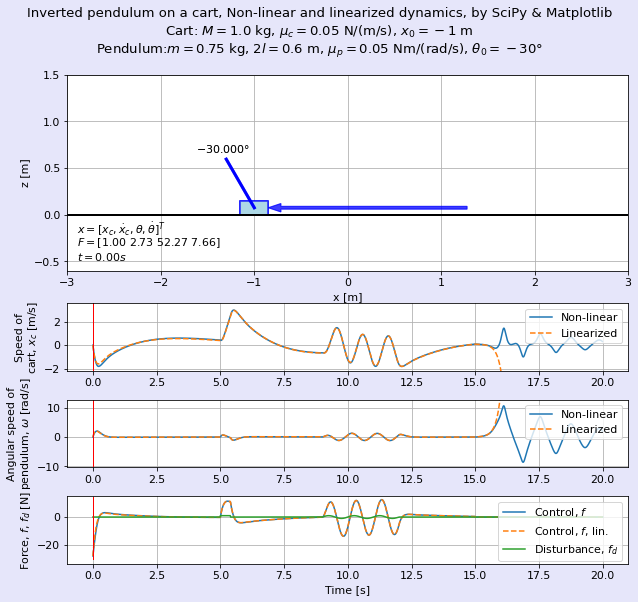

In [24]:
# Animate
# Show which one?
SHOW_NL = True
SHOW_LIN = True
alpha_lin = 0.5

# Animation setting
w_cart = 0.30          # Width of cart, m
h_cart = 0.15          # Height of cart, m
K_tscale = 3           # Size of theatre

# Plot theatre
plt.rcParams["font.size"] = 11
fig, ax = plt.subplots(4, 1, figsize = (9, 8.5), gridspec_kw={'height_ratios': [3, 1, 1, 1]})
fig.patch.set_facecolor('lavender')
ax[0].set_aspect('equal')
fig.suptitle(f'Inverted pendulum on a cart, Non-linear and linearized dynamics, by SciPy & Matplotlib\nCart: $M = {M}$ kg, $\mu_c = {mu_c}$ N/(m/s), $x_0 = {x_c0}$ m\nPendulum:$m = {m}$ kg, $2l = {2 * l}$ m, $\mu_p = {mu_p}$ Nm/(rad/s), $\\theta_0 = {theta_0}\degree$')

# Set axis for animation
ax[0].set_xlim(-K_tscale, K_tscale)
ax[0].set_xlabel('x [m]')
ax[0].set_ylim(-K_tscale / 5, K_tscale / 2)
ax[0].set_ylabel('z [m]')
ax[0].grid()
ax[0].set_axisbelow(True)

# Show state feedback gain
np.set_printoptions(formatter={'float': '{:.2f}'.format})
ax[0].text(-K_tscale + 0.1, -K_tscale / 20, '$x = [x_{c}, \\dot{x}_{c}, \\theta, \\dot{\\theta}]^T$', va = 'center')
ax[0].text(-K_tscale + 0.1, -2 * K_tscale / 20, f'$F = ${F}', va = 'center')

# Show time
text_time = ax[0].text(-K_tscale + 0.1, -3 * K_tscale / 20, f'$t = {t[0]:.2f} s$', va = 'center')

# Draw floor
ax[0].plot([-10, 10], [0, 0], lw = 2, color = 'black')

# Draw cart
# Original non-linear
cart = patches.Rectangle(xy = (x_c[0] - w_cart / 2, 0), \
    width = w_cart, height = h_cart, lw = 1.5, ec = 'blue', fc = 'lightblue')
ax[0].add_patch(cart)

# Linearized
cart_lin = patches.Rectangle(xy = (x_c_lin[0] - w_cart / 2, 0), \
    width = w_cart, height = h_cart, lw = 1.5, ec = 'blue', fc = 'lightblue', alpha = alpha_lin)
ax[0].add_patch(cart_lin)

# Draw pendulum
# Original non-linear
pendulum, = ax[0].plot([x_c[0], x_c[0] + 2 * l * np.sin(theta[0])],[h_cart / 2, h_cart / 2 + 2 * l * np.cos(theta[0])], \
    lw = 3, color = 'blue')

# Linearized
pendulum_lin, = ax[0].plot([x_c_lin[0], x_c_lin[0] + 2 * l * np.sin(theta_lin[0])], \
    [h_cart / 2, h_cart / 2 + 2 * l * np.cos(theta_lin[0])], \
    lw = 3, color = 'blue', alpha = alpha_lin)

# Show angle of pendulum over it
# Original non-linear
text_angle = ax[0].text(x_c[0] + 2 * l * 1.1 * np.sin(theta[0]), \
    h_cart / 2 + 2 * l * 1.1 * np.cos(theta[0]), \
    f'${np.degrees(theta[0]):.3f}\degree$', ha = 'center', va = 'bottom')

text_angle_lin = ax[0].text(x_c_lin[0] + 2 * l * 1.1 * np.sin(theta_lin[0]), \
    h_cart / 2 + 2 * l * 1.1 * np.cos(theta_lin[0]), \
    f'${np.degrees(theta_lin[0]):.3f}\degree$', ha = 'center', va = 'bottom', alpha = 0.3)

# Show control and disturbance forces as arrows
K_fscale = K_tscale / 40

# Original non-linear
arrow_cont = ax[0].arrow(x_c[0] - w_cart / 2 * np.sign(f_cont[0]) - K_fscale * f_cont[0], \
    h_cart / 2, K_fscale * f_cont[0], 0, length_includes_head = True, \
    width = K_tscale * 0.01, color = 'blue', alpha = 0.6)

arrow_disturb = ax[0].arrow(x_c[0] + 2 * l * np.sin(theta[0]) - K_fscale * f_disturb[0], h_cart / 2 + 2 * l * np.cos(theta[0]), \
    K_fscale * f_disturb[0], 0, length_includes_head = True, \
    width = K_tscale * 0.01, color = 'orange', alpha = 0.8)

# Linearized
arrow_cont_lin = ax[0].arrow(x_c_lin[0] - w_cart / 2 * np.sign(f_cont_lin[0]) - K_fscale * f_cont_lin[0], \
    h_cart / 2, K_fscale * f_cont_lin[0], 0, length_includes_head = True, \
    width = K_tscale * 0.01, color = 'blue', alpha = alpha_lin * 0.8)

arrow_disturb_lin = ax[0].arrow(x_c_lin[0] + 2 * l * np.sin(theta_lin[0]) - K_fscale * f_disturb_lin[0], \
    h_cart / 2 + 2 * l * np.cos(theta_lin[0]), \
    K_fscale * f_disturb_lin[0], 0, length_includes_head = True, \
    width = K_tscale * 0.01, color = 'orange', alpha = alpha_lin * 0.8)

# Time-domain plots
# Plot speed of cart
ax[1].plot(t, v_c, label = 'Non-linear', ls = '-')
ax[1].plot(t, v_c_lin, label = 'Linearized', ls = '--')
line_time_v_c, = ax[1].plot([t[0], t[0]], ax[1].get_ylim(), lw = 1, c = 'red') 
ax[1].set_ylim(np.min(v_c) * 1.2, np.max(v_c) * 1.2)
ax[1].set_ylabel('Speed of\ncart, $x_{c}$ [m/s]')
ax[1].legend(loc = 'upper right')
ax[1].grid()

# Plot angular speed of pendulum
ax[2].plot(t, omega, label = 'Non-linear', ls = '-')
ax[2].plot(t, omega_lin, label = 'Linearized', ls = '--')
line_time_omega, = ax[2].plot([t[0], t[0]], ax[2].get_ylim(), lw = 1, c = 'red')
ax[2].set_ylim(np.min(omega) * 1.2, np.max(omega) * 1.2)
ax[2].set_ylabel('Angular speed of\npendulum, $\\omega$ [rad/s]')
ax[2].legend(loc = 'upper right')
ax[2].grid()

# Plot forces
ax[3].plot(t, f_cont, label = 'Control, $f$')
ax[3].plot(t, f_cont_lin, label = 'Control, $f$, lin.', ls = '--')
ax[3].plot(t, f_disturb, label = 'Disturbance, $f_{d}$')
line_time_force, = ax[3].plot([t[0], t[0]], ax[3].get_ylim(), lw = 1, c = 'red')
ax[3].set_ylim(np.min(f_cont) * 1.2, np.max(f_cont) * 1.2)
ax[3].set_xlabel('Time [s]')
ax[3].set_ylabel('Force, $f$, $f_{d}$ [N]')
ax[3].legend(loc = 'upper right')
ax[3].grid()

fig.tight_layout()

In [25]:
# Function to update frame
def animate(i):
    # Update cart position
    # Original non-linear
    cart.set_x(x_c[i] - w_cart / 2)
    
    # Linearized
    cart_lin.set_x(x_c_lin[i] - w_cart / 2)
    
    # Update pendulum attitude
    # Original non-linear
    pendulum.set_data([x_c[i], x_c[i] + 2 * l * np.sin(theta[i])],[h_cart / 2, h_cart / 2 + 2 * l * np.cos(theta[i])])
    
    # Linearized
    pendulum_lin.set_data([x_c_lin[i], x_c_lin[i] + 2 * l * np.sin(theta_lin[i])],[h_cart / 2, h_cart / 2 + 2 * l * np.cos(theta_lin[i])])
    
    # Update pendulum angle text
    # Original non-linear
    text_angle.set_position((x_c[i] + 2 * l * 1.1 * np.sin(theta[i]), h_cart / 2 + 2 * l * 1.1 * np.cos(theta[i])))
    text_angle.set_text(f'${np.degrees(theta[i]):.3f}\degree$')
    
    # Linearized
    text_angle_lin.set_position((x_c_lin[i] + 2 * l * 1.1 * np.sin(theta_lin[i]), h_cart / 2 + 2 * l * 1.1 * np.cos(theta_lin[i])))
    text_angle_lin.set_text(f'${np.degrees(theta_lin[i]):.3f}\degree$')
    
    # Update time text
    text_time.set_text(f'$t = {t[i]:.2f}$ s')
    
    # Update force arrow
    # Original linearized
    kwargs = {'x': x_c[i] - w_cart / 2 * np.sign(f_cont[i]) - K_fscale * f_cont[i], 'dx': K_fscale * f_cont[i]}
    arrow_cont.set_data(**kwargs)
    kwargs = {'x': x_c[i] + 2 * l * np.sin(theta[i]) - K_fscale * f_disturb[i], 'y': h_cart / 2 + 2 * l * np.cos(theta[i]), 'dx': K_fscale * f_disturb[i]}
    arrow_disturb.set_data(**kwargs)
    
    # Linearized
    kwargs = {'x': x_c_lin[i] - w_cart / 2 * np.sign(f_cont_lin[i]) - K_fscale * f_cont_lin[i], 'dx': K_fscale * f_cont_lin[i]}
    arrow_cont_lin.set_data(**kwargs)
    kwargs = {'x': x_c_lin[i] + 2 * l * np.sin(theta_lin[i]) - K_fscale * f_disturb_lin[i], 'y': h_cart / 2 + 2 * l * np.cos(theta_lin[i]), 'dx': K_fscale * f_disturb_lin[i]}
    arrow_disturb_lin.set_data(**kwargs)
    
    # Update time lines
    line_time_v_c.set_data([t[i], t[i]], ax[1].get_ylim())
    line_time_omega.set_data([t[i], t[i]], ax[2].get_ylim())
    line_time_force.set_data([t[i], t[i]], ax[3].get_ylim())
    
    return (cart, pendulum, cart_lin, pendulum_lin, text_angle, text_angle_lin, text_time, line_time_v_c, line_time_omega, line_time_force)

In [26]:
# Create animation
ani = animation.FuncAnimation(fig, animate, \
    frames = np.arange(0, len(t), 5), interval = dt * 5 * 1000, blit = True)

# Show animation
HTML(ani.to_html5_video())

In [27]:
# Save animation GIF
ani.save('inverted-pendulum-LQR-example.gif')

An example of generated animation GIFs is shown below.
<figure><img src="inverted-pendulum-LQR.gif"><figcaption>Fig. 2 Generated animation GIF.</figcaption></figure>